In [2]:
# Import the various libraries
import re, json, os, itertools
import pandas as pd
from tqdm import tqdm

In [3]:
# Path to each individual txt files converted from PDF
TC_PATH = "D:\\DYPIU\\INTERNSHIP PROJECTS\\GIBOTS\\CUAD-v1\\FULL_CONTRACT_TXT"

# Path to folder containing all the CUAD data and files
MASTER_PATH = "D:\\DYPIU\\INTERNSHIP PROJECTS\\GIBOTS\\CUAD-v1"

# Name of CSV file containing all the extracted clauses from the Atticus team
MASTER_CLAUSES = 'master_clauses.csv'

# Name of JSON file to export the agreement text and labels for data extraction
JSON_EXPORT = 'CUAD_v1.json'

# Name of JSON file to export the agreement taxt and labels for further inspection
JSON_EXPORT_INSPECT = 'jsonl_cuadv1_inspect.json'

In [4]:
# Walk through all .txt filenames and create a dataframe with the names of the files, sorted alpha/num
text_files = []
for (dirpath, dirnames, filenames) in os.walk(TC_PATH):
    text_files.extend(filenames)

tf_df = pd.DataFrame(data = text_files, columns = ['Text Files'])
tf_df.sort_values('Text Files', axis=0, inplace=True, ignore_index=True) 
tf_df.head()

,Text Files
0,2ThemartComInc_19990826_10-12G_EX-10.10_670028...
1,ABILITYINC_06_15_2020-EX-4.25-SERVICES AGREEME...
2,ACCELERATEDTECHNOLOGIESHOLDINGCORP_04_24_2003-...
3,ACCURAYINC_09_01_2010-EX-10.31-DISTRIBUTOR AGR...
4,ADAMSGOLFINC_03_21_2005-EX-10.17-ENDORSEMENT A...


In [5]:
# Read master clauses CSV into a dataframe, sort by filename to match text file dataframe created above
mc_df = pd.read_csv('master_clauses.csv')

# Cut out the relevant info
mc_df_cut = mc_df[['Filename',
                   'Document Name',
                   'Document Name-Answer',
                   'Parties',
                   'Parties-Answer',
                   'Agreement Date',
                   'Agreement Date-Answer']].copy()

# Sort the dataframe by filename
mc_df_cut.sort_values('Filename', axis=0, inplace=True, ignore_index=True) 

# Bring in the list of the .txt filenames
mc_df_cut.insert(loc=1, column='Text Files', value=tf_df)

# Create a list of the names of the files, with index num
file_list = [(index, str(row['Text Files'])) for index, row in mc_df_cut.iterrows() if not pd.isna(row['Text Files'])]

In [6]:
#Initial dataframe info
mc_df_cut.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 510 entries, 0 to 509
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Filename               510 non-null    object
 1   Text Files             478 non-null    object
 2   Document Name          510 non-null    object
 3   Document Name-Answer   510 non-null    object
 4   Parties                510 non-null    object
 5   Parties-Answer         509 non-null    object
 6   Agreement Date         510 non-null    object
 7   Agreement Date-Answer  465 non-null    object
dtypes: object(8)
memory usage: 32.0+ KB


In [7]:
# Create a function to clean up and pre-process the text.
# This process should be used for any document text inc. train, validation and test sets.
def pre_process_doc_common(text):
    # Simple replacement for "\n"
    text = text.replace("\n", " ")     
    
    # Simple replacement for "\xa0"
    text = text.replace("\xa0", " ")  
    
    # Simple replacement for "\x0c"
    text = text.replace("\x0c", " ")
    
    # Get rid of multiple dots
    regex = "\ \.\ "
    subst = "."
    text = re.sub(regex, subst, text, 0)
    
    # Get rid of underscores
    regex = "_"
    subst = " "
    text = re.sub(regex, subst, text, 0)
    
    # Get rid of multiple dashes
    regex = "--+"
    subst = " "
    text = re.sub(regex, subst, text, 0)
    
    # Get rid of multiple stars
    regex = "\*+"
    subst = "*"
    text = re.sub(regex, subst, text, 0)
    
    # Get rid of multiple whitespace
    regex = "\ +"
    subst = " "
    text = re.sub(regex, subst, text, 0)
    
    #Strip leading and trailing whitespace
    text = text.strip()
  
    return text

# Function to take in the file list, read each file, clean the text and return all agreements in a list
def text_data(file_list, print_text=False, clean_text=True, max_len=3000):
    text_list = []
    for index, filename in tqdm(file_list):
        agreement = open(TC_PATH+'\\'+filename, "r")
        text = agreement.read()
        if print_text:
            print("Text before cleaning: \n", text)
        
        # Run text through cleansing function
        if clean_text:
            text = pre_process_doc_common(text)
        text = text[:max_len]
        len_text = len(text)
        
        if print_text:
            print("Text after cleaning: \n", text)
        
        text_list.append([index,
                  filename,
                  text,
                  len_text])
        
    return text_list

In [8]:
# Clean text and create dataframe with the text of ech document
# print('before file list :', file_list[477])
data = text_data(file_list, print_text=False, clean_text=True, max_len=1000)
columns = ['ID', 'Documents', 'Text', 'Length_Of_Text']
text_df = pd.DataFrame(data=data, columns=columns)

# Add the two columns to a copy of the main dataframe
mc_df_wk = mc_df_cut.copy()
mc_df_wk = mc_df_wk.join(text_df[['Text', 'Length_Of_Text']])

#Ensure agreement date, doc_name and parties are list objects
mc_df_wk["Agreement Date"] = mc_df_wk["Agreement Date"].apply(eval)
mc_df_wk["Document Name"] = mc_df_wk["Document Name"].apply(eval)
mc_df_wk["Parties"] = mc_df_wk["Parties"].apply(eval)

# Some document name references have more than one entry - remove them for further inspection later
mc_df_wk['Doc_N_Length'] = mc_df_wk['Document Name'].str.len()
mc_df_mul = mc_df_wk[mc_df_wk.Doc_N_Length > 1]
mc_df_wk.drop(mc_df_mul.index, inplace=True)

# Have a look at the data
mc_df_wk.head(3)

100%|██████████| 478/478 [00:09<00:00, 49.86it/s]


,Filename,Text Files,Document Name,Document Name-Answer,Parties,Parties-Answer,Agreement Date,Agreement Date-Answer,Text,Length_Of_Text,Doc_N_Length
0,2ThemartComInc_19990826_10-12G_EX-10.10_670028...,2ThemartComInc_19990826_10-12G_EX-10.10_670028...,[CO-BRANDING AND ADVERTISING AGREEMENT],CO-BRANDING AND ADVERTISING AGREEMENT,"[2THEMART.COM, INC., 2TheMart, i-Escrow, I-ESC...","I-ESCROW, INC. (""i-Escrow"" ); 2THEMART.COM, I...","[June 21, 1999]",6/21/99,CO-BRANDING AND ADVERTISING AGREEMENT THIS CO-...,1000.0,1
1,ABILITYINC_06_15_2020-EX-4.25-SERVICES AGREEME...,ABILITYINC_06_15_2020-EX-4.25-SERVICES AGREEME...,[Services Agreement],Services Agreement,"[""Provider"", TELCOSTAR PTE, LTD., Each of the ...","[ * * * ] (""Provider""); TELCOSTAR PTE, LTD.; A...","[October 1, 2019]",10/1/19,EXHIBIT 4.25 INFORMATION IN THIS EXHIBIT IDENT...,1000.0,1
2,ACCELERATEDTECHNOLOGIESHOLDINGCORP_04_24_2003-...,ACCELERATEDTECHNOLOGIESHOLDINGCORP_04_24_2003-...,[JOINT VENTURE AGREEMENT],JOINT VENTURE AGREEMENT,"[Pivotal Self Service Tech, Inc., (the ""Partie...","Collectible Concepts Group, Inc. (""CCGI""); Piv...",[],NaN,EXHIBIT 10.13 JOINT VENTURE AGREEMENT Collecti...,1000.0,1


In [9]:
# Check for null values
mc_df_wk.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 499 entries, 0 to 509
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Filename               499 non-null    object 
 1   Text Files             467 non-null    object 
 2   Document Name          499 non-null    object 
 3   Document Name-Answer   499 non-null    object 
 4   Parties                499 non-null    object 
 5   Parties-Answer         498 non-null    object 
 6   Agreement Date         499 non-null    object 
 7   Agreement Date-Answer  458 non-null    object 
 8   Text                   467 non-null    object 
 9   Length_Of_Text         467 non-null    float64
 10  Doc_N_Length           499 non-null    int64  
dtypes: float64(1), int64(1), object(9)
memory usage: 46.8+ KB


In [10]:
# Agreement date is an important label. Here we will drop any agreement without a date.
# These will typically be template or specimen agreements which havent been executed
# Prior to dropping, we create a dataframe to manually check and annotate agreement date in a different exercise
mc_df_nul = mc_df_wk[mc_df_wk["Agreement Date-Answer"].isnull()]
mc_df_wk = mc_df_wk.dropna(subset=['Agreement Date-Answer'])
mc_df_wk.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 458 entries, 0 to 509
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Filename               458 non-null    object 
 1   Text Files             430 non-null    object 
 2   Document Name          458 non-null    object 
 3   Document Name-Answer   458 non-null    object 
 4   Parties                458 non-null    object 
 5   Parties-Answer         458 non-null    object 
 6   Agreement Date         458 non-null    object 
 7   Agreement Date-Answer  458 non-null    object 
 8   Text                   430 non-null    object 
 9   Length_Of_Text         430 non-null    float64
 10  Doc_N_Length           458 non-null    int64  
dtypes: float64(1), int64(1), object(9)
memory usage: 42.9+ KB


In [11]:
# The CUADv1 labels includes the Party definition eg Apple Inc. "Apple", here we keep just the legal entity:
def remove_party_overlaps(labels):
    labels.sort()
    k = []
    for i in range(len(labels)-1):
        l1 = labels[i]
        l2 = labels[i+1]
        if l1[0] == l2[0]:
            len1 = l1[1] - l1[0]
            len2 = l2[1] - l2[0]
            if len1 > len2:
                k.append(l1)
                continue
            else:
                k.append(l2)
                continue
        else:
            k.append(labels[i])
    new_labels = list(k for k,_ in itertools.groupby(k))
    
    return new_labels

In [12]:
# Go through each label and find the label in the text, ensure label is pre-processed same as text.
# If labels don't match, append to a seperate file to check.

clean_text = True
djson = list()
djson_inspect = list()
for index, row in tqdm(mc_df_wk.iterrows()):
    labels = list()
    ids = index
    text = row['Text']
    
    #DOC_NAME
    doc_names = row['Document Name']
    for name in doc_names:
        if clean_text:
            name = pre_process_doc_common(name)
        type(text)
        if type(text) != str:
            text = str(text)
            
        matches = re.finditer(re.escape(name.lower()), text.lower())
        for m in matches:
            s = m.start()
            e = m.end()
            labels.append([s, e, 'DOC_NAME'])
    
    #AGMT_DATE
    agmt_date = row['Agreement Date']
    for date in agmt_date:
        if clean_text:
            date = pre_process_doc_common(date)
        matches = re.finditer(re.escape(date.lower()), text.lower())
        for m in matches:
            s = m.start()
            e = m.end()
            labels.append([s, e, 'AGMT_DATE'])

    #PARTIES
    parties = row['Parties']
    for party in parties:
        if clean_text:
            party = pre_process_doc_common(party)
        matches = re.finditer(re.escape(party.lower()), text.lower())
        for m in matches:
            s = m.start()
            e = m.end()
            labels.append([s, e, 'PARTY'])
    
    labels = remove_party_overlaps(labels)
    #print(labels)
    
    # Check for incongruous finds, add to inspect file
    flat_list = [item for sublist in labels for item in sublist]
    if 'DOC_NAME' in flat_list and 'AGMT_DATE' in flat_list and 'PARTY' in flat_list:
        djson.append({'id': ids, 'text': text, "labels": labels})
    else:
        djson_inspect.append({'id': ids, 'text': text, "labels": labels})

# Add to the check JSON file the other documents excluded due to duplicate names and no agreement dates
for index, row in tqdm(mc_df_mul.iterrows()):
    labels = list()
    ids = index
    text = row['Text']
    djson_inspect.append({'id': ids, 'text': text, "labels": labels})

for index, row in tqdm(mc_df_nul.iterrows()):
    labels = list()
    ids = index
    text = row['Text']
    djson_inspect.append({'id': ids, 'text': text, "labels": labels})

458it [00:00, 934.45it/s]
11it [00:00, ?it/s]
41it [00:00, ?it/s]


In [13]:
# The process above requires the three label types to be present in each agreement extract. This may not
# be the case due to the shortening of the agreememt for example. Let's check how many we are left with
# and how many we need to manually check...
print(f"We are left with {len(djson)} training samples out of 510 to annotate.")
print("Additional agreements to check: ",len(djson_inspect))

We are left with 28 training samples out of 510 to annotate.
Additional agreements to check:  482


In [14]:
# Check for erroneous labels
count = 0
for n in range(len(djson)):
    labs = djson[n]['labels']
    flat_list = [item for sublist in labs for item in sublist]
    if -1 in flat_list:
        count += 1
print(count)

0


In [15]:
# Export the full datasets for import to Doccano
filepath = JSON_EXPORT
open(filepath, 'w').write("\n".join([json.dumps(e) for e in djson]))

filepath = JSON_EXPORT_INSPECT
open(filepath, 'w').write("\n".join([json.dumps(e) for e in djson_inspect]))

517591

In [16]:
from transformers import AutoModelForQuestionAnswering, AutoTokenizer
import torch

In [17]:
model = AutoModelForQuestionAnswering.from_pretrained('D:\\DYPIU\\INTERNSHIP PROJECTS\\GIBOTS\\Roberta base model')
tokenizer = AutoTokenizer.from_pretrained('D:\\DYPIU\\INTERNSHIP PROJECTS\\GIBOTS\\Roberta base model', use_fast=False)

In [18]:
import json

with open('D:\\DYPIU\\INTERNSHIP PROJECTS\\GIBOTS\\CUAD_v1.json') as json_file:
    data = json.load(json_file)

question = data['data'][0]['paragraphs'][0]['qas'][3]['question']
paragraph = ' '.join(data['data'][3]['paragraphs'][0]['context'].split()[:100])

In [19]:
encoding = tokenizer.encode_plus(text=question, text_pair=paragraph)
inputs = encoding['input_ids']
tokens = tokenizer.convert_ids_to_tokens(inputs)
outputs = model(input_ids=torch.tensor([inputs]))

start_scores = outputs.start_logits
end_scores = outputs.end_logits

In [20]:
print(question)

Highlight the parts (if any) of this contract related to "Effective Date" that should be reviewed by a lawyer. Details: The date when the contract is effective 


In [21]:
print(paragraph)

1 Exhibit 10.3 I-on. (LOGO) www.i-on.com 561.394.9484 o 561.394-9773 fax 1733 avenida del sol, boca raton, florida, 33432 WEB SITE HOSTING AGREEMENT This WEB SITE HOSTING AGREEMENT ("this Agreement") is entered into this 6th day of April, 1999 by and between Centrack International, a Florida corporation ("the Customer"), and i-on interactive, a Florida corporation ("i-on"). DEFINITIONS As used in this Agreement, the term "Web site" shall mean a computer system intended to be accessed through the World Wide Web segment of the Internet, including software and content intended to be viewed and/or operated upon by persons accessing the computer system


In [22]:
start_index = torch.argmax(start_scores)
end_index = torch.argmax(end_scores)
answer = tokenizer.convert_tokens_to_string(tokens[start_index:end_index+1])
answer.strip()

'6th day of April, 1999'

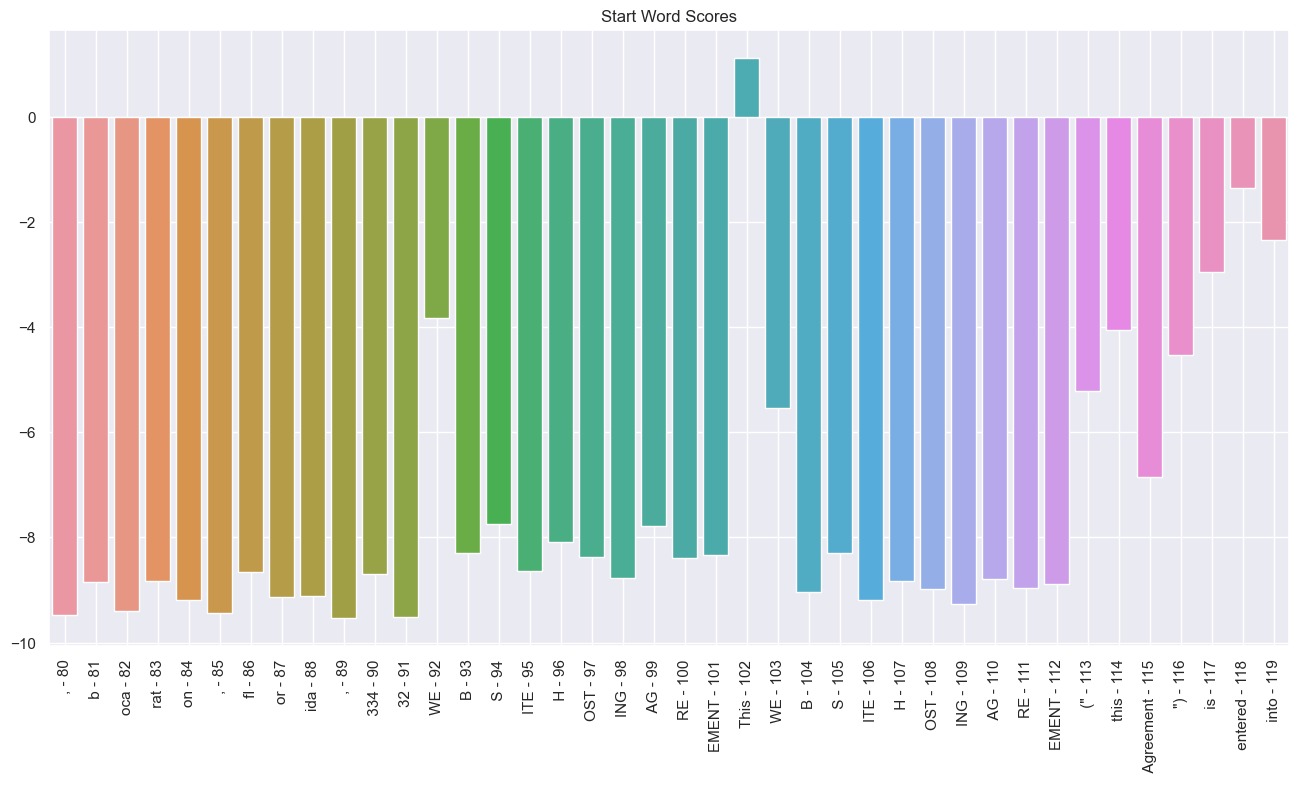

In [23]:
#first chart depicts the probabilities for each token in the contract to be the start token of the answer, 
#the second does the same but for the end tokens:

import matplotlib.pyplot as plt
import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
#sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (16,8)

# Pull the scores out of PyTorch Tensors and convert them to 1D numpy arrays.
s_scores = start_scores.detach().numpy().flatten()
e_scores = end_scores.detach().numpy().flatten()

# We'll use the tokens as the x-axis labels. In order to do that, they all need
# to be unique, so we'll add the token index to the end of each one.
token_labels = []
for (i, token) in enumerate(tokens):
    token_labels.append('{:} - {:>2}'.format(tokenizer.convert_tokens_to_string(token), i))

# Create a barplot showing the start word score for all of the tokens.
ax = sns.barplot(x=token_labels[80:120], y=s_scores[80:120], ci=None)

# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

# Turn on the vertical grid to help align words to scores.
ax.grid(True)

plt.title('Start Word Scores')

plt.show()

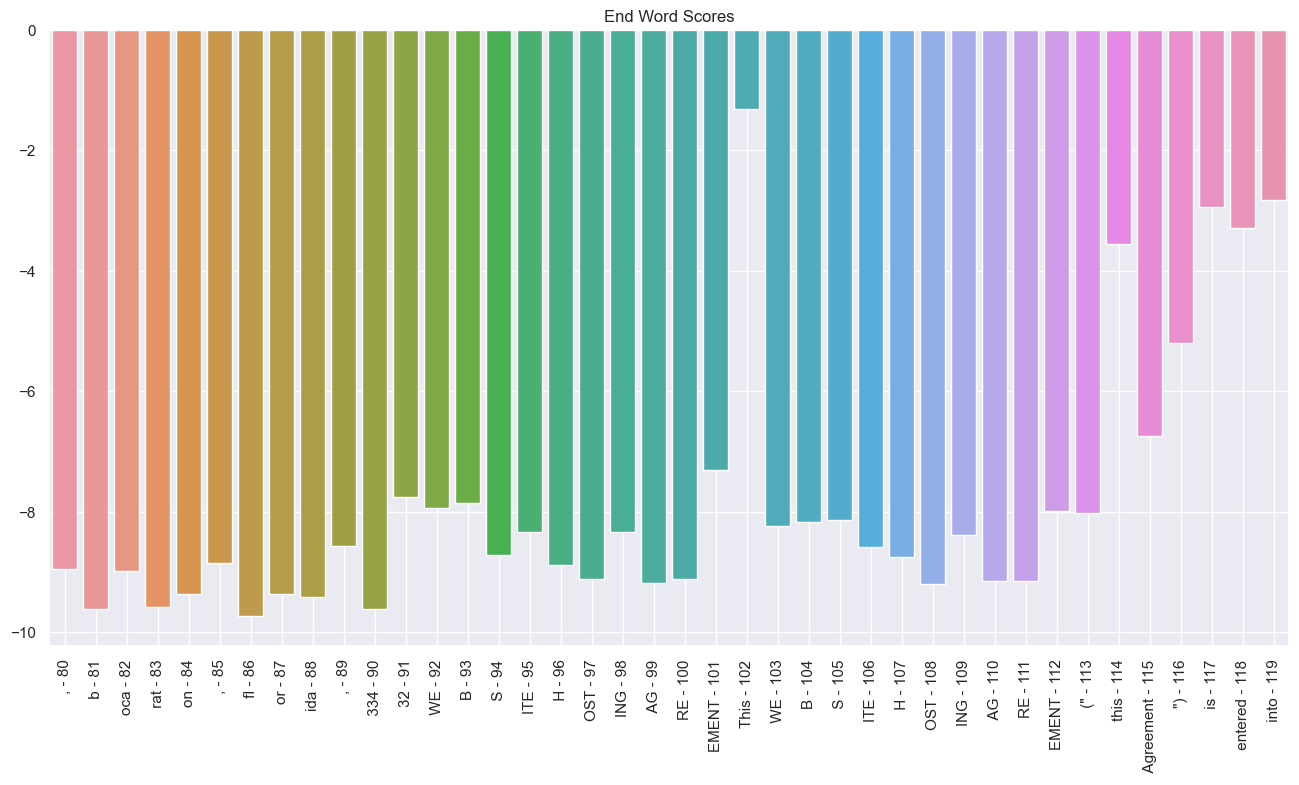

In [24]:
# Create a barplot showing the end word score for all of the tokens.
ax = sns.barplot(x=token_labels[80:120], y=e_scores[80:120], ci=None)

# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

# Turn on the vertical grid to help align words to scores.
ax.grid(True)

plt.title('End Word Scores')

plt.show()

In [25]:
import json
from transformers import AutoTokenizer

with open('D:\\DYPIU\\INTERNSHIP PROJECTS\\GIBOTS\\CUAD_v1.json') as json_file:
    data = json.load(json_file)

tokenizer = AutoTokenizer.from_pretrained('D:\\DYPIU\\INTERNSHIP PROJECTS\\GIBOTS\\Roberta base model', use_fast=False)
    
l = []
for i, x in enumerate(data['data']):
    l.append(len(tokenizer.encode(data['data'][i]['paragraphs'][0]['context'])))

print(f"Contracts with token length < 512: {sum(1 for x in l if x < 512) / len(l) * 100:.1f}%")


Token indices sequence length is longer than the specified maximum sequence length for this model (23250 > 512). Running this sequence through the model will result in indexing errors


Contracts with token length < 512: 2.4%


In [1]:
import torch
import time
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

from transformers import (
    AutoConfig,
    AutoModelForQuestionAnswering,
    AutoTokenizer,
    squad_convert_examples_to_features
)

from transformers.data.processors.squad import SquadResult, SquadV2Processor, SquadExample
from transformers.data.metrics.squad_metrics import compute_predictions_logits
#from transformers import pipeline

def run_prediction(question_texts, context_text, model_path):
    ### Setting hyperparameters
    max_seq_length = 512
    doc_stride = 256
    n_best_size = 1
    max_query_length = 64
    max_answer_length = 512
    do_lower_case = False
    null_score_diff_threshold = 0.0

    # model_name_or_path = "../cuad-models/roberta-base/"

    def to_list(tensor):
        return tensor.detach().cpu().tolist()

    config_class, model_class, tokenizer_class = (
        AutoConfig, AutoModelForQuestionAnswering, AutoTokenizer)
    config = config_class.from_pretrained(model_path)
    tokenizer = tokenizer_class.from_pretrained(
        model_path, do_lower_case=True, use_fast=False)
    model = model_class.from_pretrained(model_path, config=config)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    processor = SquadV2Processor()
    examples = []

    for i, question_text in enumerate(question_texts):
        example = SquadExample(
            qas_id=str(i),
            question_text=question_text,
            context_text=context_text,
            answer_text=None,
            start_position_character=None,
            title="Predict",
            answers=None,
        )

        examples.append(example)

    features, dataset = squad_convert_examples_to_features(
        examples=examples,
        tokenizer=tokenizer,
        max_seq_length=max_seq_length,
        doc_stride=doc_stride,
        max_query_length=max_query_length,
        is_training=False,
        return_dataset="pt",
        threads=1,
    )

    eval_sampler = SequentialSampler(dataset)
    eval_dataloader = DataLoader(dataset, sampler=eval_sampler, batch_size=10)

    all_results = []

    for batch in eval_dataloader:
        model.eval()
        batch = tuple(t.to(device) for t in batch)

        with torch.no_grad():
            inputs = {
                "input_ids": batch[0],
                "attention_mask": batch[1],
                "token_type_ids": batch[2],
            }

            example_indices = batch[3]

            outputs = model(**inputs)

            for i, example_index in enumerate(example_indices):
                eval_feature = features[example_index.item()]
                unique_id = int(eval_feature.unique_id)

                output = [to_list(output[i]) for output in outputs.to_tuple()]

                start_logits, end_logits = output
                result = SquadResult(unique_id, start_logits, end_logits)
                all_results.append(result)

    final_predictions = compute_predictions_logits(
        all_examples=examples,
        all_features=features,
        all_results=all_results,
        n_best_size=n_best_size,
        max_answer_length=max_answer_length,
        do_lower_case=do_lower_case,
        output_prediction_file=None,
        output_nbest_file=None,
        output_null_log_odds_file=None,
        verbose_logging=False,
        version_2_with_negative=True,
        null_score_diff_threshold=null_score_diff_threshold,
        tokenizer=tokenizer
    )

    return final_predictions

In [2]:
import json

In [3]:
with open('D:\\DYPIU\\INTERNSHIP PROJECTS\\GIBOTS\\CUAD_v1.json') as json_file:
    data = json.load(json_file)

In [4]:
questions = []
for i, q in enumerate(data['data'][0]['paragraphs'][0]['qas']):
    question = data['data'][0]['paragraphs'][0]['qas'][i]['question']
    questions.append(question)
#contract = data['data'][0]['paragraphs'][0]['context']

In [5]:
with open('MSA.txt', 'r', encoding='utf-8') as f1: 
    contract = f1.read() #some of the common encodings are utf-8, utf-16 and latin-1
contract = ' '.join(contract.split())

In [6]:
with open('MSA.txt', 'w') as f:
    f.write(' '.join(contract.split()))

In [7]:
predictions = run_prediction(questions, contract, 'D:\\DYPIU\\INTERNSHIP PROJECTS\\GIBOTS\\Roberta base model')

add example index and unique id: 100%|██████████| 41/41 [00:00<00:00, 5126.29it/s]


In [8]:
with open('MSA_Output.txt', 'w') as f:
    for i, p in enumerate(predictions):
        f.write(f"Question {i+1}: {questions[int(p)]}\nAnswer: {predictions[p]}\n\n")

### JSON file as output

In [9]:
import json
# Create a dictionary for predictions
output_data = {}
for i, p in enumerate(predictions):
    output_data[f"Question {i+1}"] = {
        'Question': questions[int(p)],
        'Answer': predictions[p]
    }

# Save predictions to a JSON file
output_file_path = 'MSA.json'
with open(output_file_path, 'w') as json_file:
    json.dump(output_data, json_file)

In [81]:
import json

# Assuming you have the cleaned text stored in the 'contract' variable

# Create a Python dictionary with the cleaned text
output_data = {'contract': contract}

# Specify the file path for the JSON file
output_file_path = 'output.json'

# Save the data to a JSON file
with open(output_file_path, 'w') as json_file:
    json.dump(output_data, json_file)

### Extracting Name, Date and Parties involved

In [14]:
import json

# Load the JSON data containing questions and context
with open('D:\\DYPIU\\INTERNSHIP PROJECTS\\GIBOTS\\CUAD_v1.json') as json_file:
    data = json.load(json_file)

# Extract the questions and the desired file's context
questions = [
    "Document Name",
    "Parties",
    "Agreement Date"
]

contract_path = 'Sample2.txt'
with open(contract_path, 'r') as file:
    contract_text = file.read()

# Make predictions on the specific file
predictions = run_prediction(questions, contract_text, 'D:\\DYPIU\\INTERNSHIP PROJECTS\\GIBOTS\\Roberta base model')

# Write the predictions with the corresponding clauses to a file
with open('predictions2.txt', 'w') as f:
    for i, p in enumerate(predictions):
        clause_index = int(p)

add example index and unique id: 100%|██████████| 3/3 [00:00<00:00, 3009.55it/s]


In [15]:
predictions

OrderedDict([('0', ''),
             ('1', 'WPD Pharmaceuticals,'),
             ('2', 'March 20, 2020')])

In [17]:
import json

# Load the JSON data containing questions and context
with open('D:\\DYPIU\\INTERNSHIP PROJECTS\\GIBOTS\\CUAD_v1.json') as json_file:
    data = json.load(json_file)

# Extract the questions
questions = [
    "Document Name",
    "Parties",
    "Agreement Date"
]

# Update the contract_path variable with the correct file path
contract_path = 'Test Contract(GIBots).txt'

# Read the contract file and store the text
with open(contract_path, 'r') as file:
    contract_text = file.read()

# Make predictions on the specific file
predictions = run_prediction(questions, contract_text, 'D:\\DYPIU\\INTERNSHIP PROJECTS\\GIBOTS\\Roberta base model')

# Write the predicted clauses to a file
with open('predictions.txt', 'w') as f:
    for i, p in enumerate(predictions):
        clause_index = int(p)
        clause_text = contract_text[clause_index:]
        f.write(f"Question {i+1} Clause: {clause_text}\n")

add example index and unique id: 100%|██████████| 3/3 [00:00<00:00, 3001.65it/s]


In [18]:
predictions

OrderedDict([('0', 'SUBCONTRACTOR SERVICES AGREEMENT'),
             ('1', 'Vendor Pvt. Ltd.'),
             ('2', '')])

In [9]:
import json

# Load the JSON data containing questions and context
with open('D:\\DYPIU\\INTERNSHIP PROJECTS\\GIBOTS\\CUAD_v1.json') as json_file:
    data = json.load(json_file)

# Extract the questions
questions = [
    "Highlight the parts (if any) of this contract related to 'Document Name' that should be reviewed by a lawyer.",
    "Highlight the parts (if any) of this contract related to 'Parties' that should be reviewed by a lawyer.",
    "Highlight the parts (if any) of this contract related to 'Agreement Date' that should be reviewed by a lawyer."
]

# Update the contract_path variable with the correct file path
contract_path = 'prediction.txt'

# Read the contract file and store the text
with open(contract_path, 'r') as file:
    contract_text = file.read()

# Make predictions on the specific file
predictions = run_prediction(questions, contract_text, 'D:\\DYPIU\\INTERNSHIP PROJECTS\\GIBOTS\\Roberta base model')

# Write the predicted clauses to a file
with open('predictions3.txt', 'w') as f:
    for i, p in enumerate(predictions):
        clause_index = int(p)
        clause_text = contract_text[clause_index:]
        f.write(f"Question {i+1} Clause: {clause_text}\n")

add example index and unique id: 100%|██████████| 3/3 [00:00<?, ?it/s]


In [10]:
predictions

OrderedDict([('0', 'CO-BRANDING AND ADVERTISING AGREEMENT'),
             ('1', 'I-ESCROW, INC.,'),
             ('2', 'June 21, 1999')])

### PDF file as input

In [ ]:
import json
from PyPDF2 import PdfReader
import torch
from transformers import AutoConfig, AutoModelForQuestionAnswering, AutoTokenizer


def run_prediction(questions, contract, model_path):
    from transformers import (
    AutoConfig,
    AutoModelForQuestionAnswering,
    AutoTokenizer,
    squad_convert_examples_to_features
)

from transformers.data.processors.squad import SquadResult, SquadV2Processor, SquadExample
from transformers.data.metrics.squad_metrics import compute_predictions_logits
#from transformers import pipeline

def run_prediction(question_texts, context_text, model_path):
    ### Setting hyperparameters
    max_seq_length = 512
    doc_stride = 256
    n_best_size = 1
    max_query_length = 64
    max_answer_length = 512
    do_lower_case = False
    null_score_diff_threshold = 0.0

    # model_name_or_path = "../cuad-models/roberta-base/"

    def to_list(tensor):
        return tensor.detach().cpu().tolist()

    config_class, model_class, tokenizer_class = (
        AutoConfig, AutoModelForQuestionAnswering, AutoTokenizer)
    config = config_class.from_pretrained(model_path)
    tokenizer = tokenizer_class.from_pretrained(
        model_path, do_lower_case=True, use_fast=False)
    model = model_class.from_pretrained(model_path, config=config)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    processor = SquadV2Processor()
    examples = []

    for i, question_text in enumerate(question_texts):
        example = SquadExample(
            qas_id=str(i),
            question_text=question_text,
            context_text=context_text,
            answer_text=None,
            start_position_character=None,
            title="Predict",
            answers=None,
        )

        examples.append(example)

    features, dataset = squad_convert_examples_to_features(
        examples=examples,
        tokenizer=tokenizer,
        max_seq_length=max_seq_length,
        doc_stride=doc_stride,
        max_query_length=max_query_length,
        is_training=False,
        return_dataset="pt",
        threads=1,
    )

    eval_sampler = SequentialSampler(dataset)
    eval_dataloader = DataLoader(dataset, sampler=eval_sampler, batch_size=10)

    all_results = []

    for batch in eval_dataloader:
        model.eval()
        batch = tuple(t.to(device) for t in batch)

        with torch.no_grad():
            inputs = {
                "input_ids": batch[0],
                "attention_mask": batch[1],
                "token_type_ids": batch[2],
            }

            example_indices = batch[3]

            outputs = model(**inputs)

            for i, example_index in enumerate(example_indices):
                eval_feature = features[example_index.item()]
                unique_id = int(eval_feature.unique_id)

                output = [to_list(output[i]) for output in outputs.to_tuple()]

                start_logits, end_logits = output
                result = SquadResult(unique_id, start_logits, end_logits)
                all_results.append(result)

    final_predictions = compute_predictions_logits(
        all_examples=examples,
        all_features=features,
        all_results=all_results,
        n_best_size=n_best_size,
        max_answer_length=max_answer_length,
        do_lower_case=do_lower_case,
        output_prediction_file=None,
        output_nbest_file=None,
        output_null_log_odds_file=None,
        verbose_logging=False,
        version_2_with_negative=True,
        null_score_diff_threshold=null_score_diff_threshold,
        tokenizer=tokenizer
    )

    return final_predictions

# Read questions from JSON file
with open('D:\\DYPIU\\INTERNSHIP PROJECTS\\GIBOTS\\CUAD_v1.json') as json_file:
    data = json.load(json_file)

questions = []
for qa in data['data'][0]['paragraphs'][0]['qas']:
    question = qa['question']
    questions.append(question)

# Read contract from PDF file
contract_path = 'MSA.pdf'
with open(contract_path, 'rb') as f:
    pdf_reader = PdfReader(f)
    contract = ""
    for page in pdf_reader.pages:
        contract += page.extract_text()

# Run predictions
model_path = 'D:\\DYPIU\\INTERNSHIP PROJECTS\\GIBOTS\\Roberta base model'
predictions = run_prediction(questions, contract, model_path)

# Write predictions to output file
output_path = 'MSA_output.txt'
with open(output_path, 'w') as f:
    for i, p in enumerate(predictions):
        question = questions[i]
        answer = predictions[p]
        f.write(f"Question {i+1}: {question}\nAnswer: {answer}\n\n")